## XGBoost Bio

Let's begin by installing and importing some libraries that are needed to run this experiment

In [52]:
!pip install scikit-learn
!pip install xgboost
!pip install pandas
!pip install matplotlib

import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with 

First things first. Let's load some dummy dataset. I've downloaded the data 'BostonHousing'. The data can be found in this link [https://github.com/selva86/datasets/blob/master/BostonHousing.csv](https://github.com/selva86/datasets/blob/master/BostonHousing.csv)

In [53]:
df = pd.read_csv("./BostonHousing.csv", sep=",")
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


We'll predict the 'medv' column from rest of the data

In [54]:
x, y = df.iloc[:, :-1], df.iloc[:, -1]

Now we have to split the data in train-test. This is done to check whether our model generalizes well or not. The numbers we should report must be on test data. Only fitting on train data and reporting on train data only makes no sense.

In [55]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

The next step is a bit involved. We'll do a grid search of hyperparameters to report the best test accuracy. 

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # This is a pre-processing step if you want to scale your data
steps = [('scaler', StandardScaler()), ('xgb_model', xgb.XGBRegressor())]
pipeline = Pipeline(steps)



In [57]:
from sklearn.model_selection import RandomizedSearchCV # You can also use GridSearchCV

# Create the parameter grid
gbm_param_grid = {
    'xgb_model__learning_rate': np.arange(0.05, 1, 0.05),
    'xgb_model__max_depth': np.arange(3, 10, 1),
    'xgb_model__n_estimators': np.arange(50, 200, 50)
}

# Perform RandomizedSearchCV
# For the scoring parameter, we'll use 'neg_mean_squared_error' or 'neg_root_mean_squared_error'
randomized_mse = RandomizedSearchCV(estimator=pipeline, param_distributions=gbm_param_grid,
                                        n_iter=2, scoring='neg_mean_squared_error', cv=2, verbose=1)

In [58]:
# Fit the estimator
randomized_mse.fit(x, y)

# Compute metrics
print(f'Score: {randomized_mse.best_score_}')
estimator = randomized_mse.best_estimator_
print(f'Estimator: {randomized_mse.best_estimator_}')


Fitting 2 folds for each of 2 candidates, totalling 4 fits


Score: -24.884905924046183
Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb_model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.5,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=9, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=Non

In [59]:
print(f'Test Score: {estimator.score(x_test, y_test)}')


Test Score: 0.9999999884806401


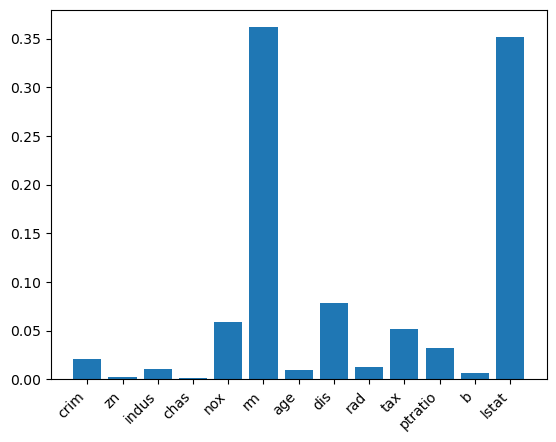

In [60]:
import matplotlib.pyplot as plt
model = estimator[-1]
# model.get_booster().get_score(importance_type='weight')
feature_names = df.columns[:-1]
bars = feature_names
y_pos = np.arange(len(bars))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xticks(y_pos, feature_names, color='black', rotation=45, horizontalalignment='right')
plt.show()